In [1]:
# Extract Spike Data from Trials Across Time Windows
# --------------------------------------------------------------
# This notebook helps you extract spike data aligned to behavioral trials,
# for different time windows such as fixation, onset, and post-trial.
# You will compute firing rates and spike counts for each trial and neuron.

import numpy as np
import pandas as pd
import scipy.io
import re

In [2]:
# === STEP 1: Load Required Data ===
# These are your input files saved from preprocessing steps.
spike_data_path = "spike_data.csv"
periods_path = "stacked_subjects_sessions_data.csv"
timestamps_path = "timestampsOfCellAll.mat"
behavior_path = "behavior.csv"

# Load neuron metadata, trial periods, and behavior labels
neurons_df = pd.read_csv(spike_data_path)
periods_df = pd.read_csv(periods_path)
behavior_df = pd.read_csv(behavior_path)

# Standardize behavior column names for consistency
behavior_df.rename(columns={
    "stimulus_index": "Image ID",
    "identity": "Identity",
    "recognition": "Recognition"
}, inplace=True)

# Load spike timestamps (from MATLAB file)
timestamps_of_cell = scipy.io.loadmat(timestamps_path)["timestampsOfCellAll"]

In [3]:
# === Utility Functions ===
# Get spikes between a start and end time
def get_spikes_per_trial(spike_times, start_time, end_time):
    return spike_times[(spike_times >= start_time) & (spike_times < end_time)]

# Clean up session name like "Sess1" to "s1"
def clean_session_name(session):
    import re
    match = re.search(r"(S|Sess)(\d+)", session, re.IGNORECASE)
    if match:
        return f"s{match.group(2)}"
    else:
        return "unknown"

# Extract number from subject ID like "p6WV" to "6"
def extract_subject_number(subject_id):
    import re
    match = re.search(r"\d+", subject_id)
    if match:
        return match.group()
    else:
        return "0"

# === Subject Mapping ===
subject_mapping = {
    'p6WV': 1, 'p7WV': 2, 'p9WV': 3, 'p10WV': 4, 'p11WV': 5, 'p13WV': 6,
    'p14WV': 7, 'p15WV': 8, 'p16WV': 9, 'p18WV': 10, 'p19WV': 11, 'p20WV': 12
}

# === Main Spike Extraction Function ===
def process_time_window(start_offset_ms, end_offset_ms, label, output_list):
    """
    Extract spike data for a specific time window.

    Parameters:
    - start_offset_ms: Window start relative to trial start (in ms)
    - end_offset_ms: Window end relative to trial start (in ms)
    - label: Label for the time window
    - output_list: List to store processed data
    """

    for session in neurons_df["session_id"].unique():
        subject_id = session.split("_")[0]
        session_id = session.split("_")[-1]

        session_clean = clean_session_name(session)
        session_number = extract_subject_number(session_clean)

        subject_number = subject_mapping.get(subject_id, -1)
        if subject_number == -1:
            print(f"Warning: Subject ID '{subject_id}' not found in mapping.")
            continue

        # === NEW === Skip exactly these two sessions
        if session in ["p10WV_CelebA_Sess3", "p11WV_CelebA_Sess5"]:
            print(f"Skipping bad session {session}.")
            continue

        neurons_session = neurons_df[neurons_df["session_id"] == session]
        periods_session = periods_df[periods_df["subject_session"] == session]
        behavior_session = behavior_df[
            (behavior_df["subject"] == subject_id) &
            (behavior_df["session"].str.lower() == session_id.lower())
        ]

        if behavior_session.empty:
            print(f"No behavior data for {subject_id}, {session_id}. Skipping...")
            continue

        for _, neuron_row in neurons_session.iterrows():
            neuron_idx = neuron_row["neuron_id"]
            neuron_area = neuron_row["area"]

            try:
                spike_times = np.array(timestamps_of_cell[0][neuron_idx]).astype(float)
                if spike_times.size == 0:
                    continue
            except IndexError:
                continue

            for trial_idx in range(min(len(periods_session), len(behavior_session))):
                trial_aligned_start = periods_session.iloc[trial_idx, 1]

                # Define absolute window in microseconds
                start_time_abs = trial_aligned_start + start_offset_ms * 1000
                end_time_abs = trial_aligned_start + end_offset_ms * 1000

                spikes_in_window = get_spikes_per_trial(spike_times, start_time_abs, end_time_abs)

                # Convert window times to seconds
                start_time_s = start_offset_ms / 1000.0
                end_time_s = end_offset_ms / 1000.0

                trial_row = behavior_session.iloc[trial_idx]
                image_id = trial_row["Image ID"]
                identity = trial_row["Identity"]
                recognition = trial_row["Recognition"]

                aligned_spikes_s = (spikes_in_window - trial_aligned_start) / 1_000_000

                trial_id = trial_idx + 1
                new_neuron_id = f"{subject_number}{neuron_idx}{trial_id}{session_number}"

                output_list.append({
                    "New Neuron ID": new_neuron_id,
                    "Subject ID": subject_number,
                    "Session": session_clean,
                    "Neuron ID": neuron_idx,
                    "Neuron Area": neuron_area,
                    "Trial ID": trial_id,
                    "Start Time (s)": start_time_s,
                    "End Time (s)": end_time_s,
                    "Spike Counts": len(spikes_in_window),
                    "Image ID": image_id,
                    "Identity": identity,
                    "Recognition": recognition,
                    "Trial-Aligned Spikes (s)": aligned_spikes_s.tolist()
                })

In [4]:
# === STEP 3: Run the Function for Each Time Window ===
# Windows are defined in seconds now (0–2.0 seconds)

spike_fixation = []  # 0.0–0.5 s: fixation (before stimulus onset)
spike_stimulus = []  # 0.5–1.5 s: stimulus + ISI
spike_iti = []       # 1.5–2.0 s: post-stimulus rest (ITI)
spike_mid = []       # 0.25–1.25 s: mid-response window
spike_full = []      # 0.0–2.0 s: entire trial

# Convert seconds to milliseconds inside the function call
process_time_window(0, 500, "fixation", spike_fixation)       # 0.0s to 0.5s
process_time_window(500, 1500, "stimulus", spike_stimulus)    # 0.5s to 1.5s
process_time_window(1500, 2000, "iti", spike_iti)             # 1.5s to 2.0s
process_time_window(250, 1250, "mid", spike_mid)              # 0.25s to 1.25s
process_time_window(0, 2000, "full", spike_full)              # 0.0s to 2.0s

# === STEP 4: Save Everything to CSV Files ===
def save_spike_data(spike_data, filename):
    """
    Save a list of spike data dictionaries to a CSV file.

    Parameters:
    - spike_data: list of dictionaries
    - filename: string filename to save
    """
    df = pd.DataFrame(spike_data)
    df.to_csv(filename, index=False)

# Save each time window to a separate CSV
save_spike_data(spike_fixation, "spikes_fixation.csv")
save_spike_data(spike_stimulus, "spikes_stimulus.csv")
save_spike_data(spike_iti, "spikes_iti.csv")
save_spike_data(spike_mid, "spikes_mid.csv")
save_spike_data(spike_full, "spikes_full.csv")

print("All spike window CSV files saved successfully.")

Skipping bad session p10WV_CelebA_Sess3.
Skipping bad session p11WV_CelebA_Sess5.
Skipping bad session p10WV_CelebA_Sess3.
Skipping bad session p11WV_CelebA_Sess5.
Skipping bad session p10WV_CelebA_Sess3.
Skipping bad session p11WV_CelebA_Sess5.
Skipping bad session p10WV_CelebA_Sess3.
Skipping bad session p11WV_CelebA_Sess5.
Skipping bad session p10WV_CelebA_Sess3.
Skipping bad session p11WV_CelebA_Sess5.
All spike window CSV files saved successfully.


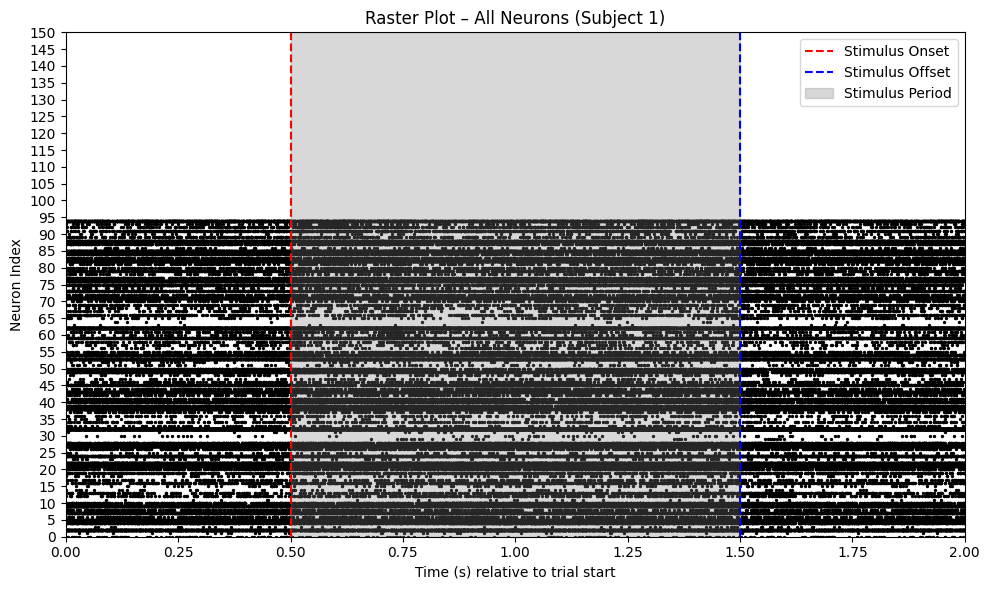

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# === STEP 1: Load Your Spike Data ===
df = pd.read_csv("spikes_full.csv")

# === STEP 2: Choose Subject ===
subject_id = 1
df = df[df["Subject ID"] == subject_id].copy()

# === STEP 3: Convert spike time strings to real lists  ===
parsed_spikes = []
for item in df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === STEP 4: Aggregate spikes by neuron ===
neuron_ids = sorted(df["Neuron ID"].unique())
neuron_map = {}

for index, neuron_id in enumerate(neuron_ids):
    neuron_map[neuron_id] = index  # Map neuron ID to row index

raster_spike_times = []
raster_neuron_indices = []

# Collect spikes for each neuron
for neuron_id in neuron_ids:
    neuron_index = neuron_map[neuron_id]
    neuron_trials = df[df["Neuron ID"] == neuron_id]["Trial-Aligned Spikes (s)"]

    for spike_list in neuron_trials:
        for spike_time in spike_list:
            raster_spike_times.append(spike_time)
            raster_neuron_indices.append(neuron_index)

# === STEP 5: Plot ===
max_neurons_to_show = 150  # Always show up to 150 neurons

plt.figure(figsize=(10, 6))

# Plot real spike points
plt.scatter(raster_spike_times, raster_neuron_indices, s=2, color='black')

# Add stimulus onset and offset
plt.axvline(0.5, color='red', linestyle='--', label="Stimulus Onset")
plt.axvline(1.5, color='blue', linestyle='--', label="Stimulus Offset")

# === Add stimulus shading (better like MATLAB) ===
plt.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

# Labels and formatting
plt.xlabel("Time (s) relative to trial start")
plt.ylabel("Neuron Index")
plt.title(f"Raster Plot – All Neurons (Subject {subject_id})")
plt.xlim([0, 2.0])  # Full trial window is 0 to 2 seconds
plt.ylim([0, max_neurons_to_show])
plt.yticks(np.arange(0, max_neurons_to_show + 1, 5))  # Tick every 5 neurons
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# HOW MANY NEURONS DOES ONE SUBJECT HAVE?

import pandas as pd

# === STEP 1: Load the Spike Data ===
# This file should include all neurons, trials, and subjects
df = pd.read_csv("spikes_full.csv")

# === STEP 2: Choose a Subject to Analyze ===
# Replace this with any subject ID you're interested in
subject_id = 1

# === STEP 3: Filter the Data for That Subject Only ===
# We'll keep only the rows that belong to the selected subject
df_subject = df[df["Subject ID"] == subject_id].copy()

# === STEP 4: Find Unique Neurons for This Subject ===
# We use .unique() to get all distinct neuron IDs
neurons = df_subject["Neuron ID"].unique()

# === STEP 5: Print the Result ===
print(f"Number of neurons for subject {subject_id}: {len(neurons)}")

Number of neurons for subject 1: 95


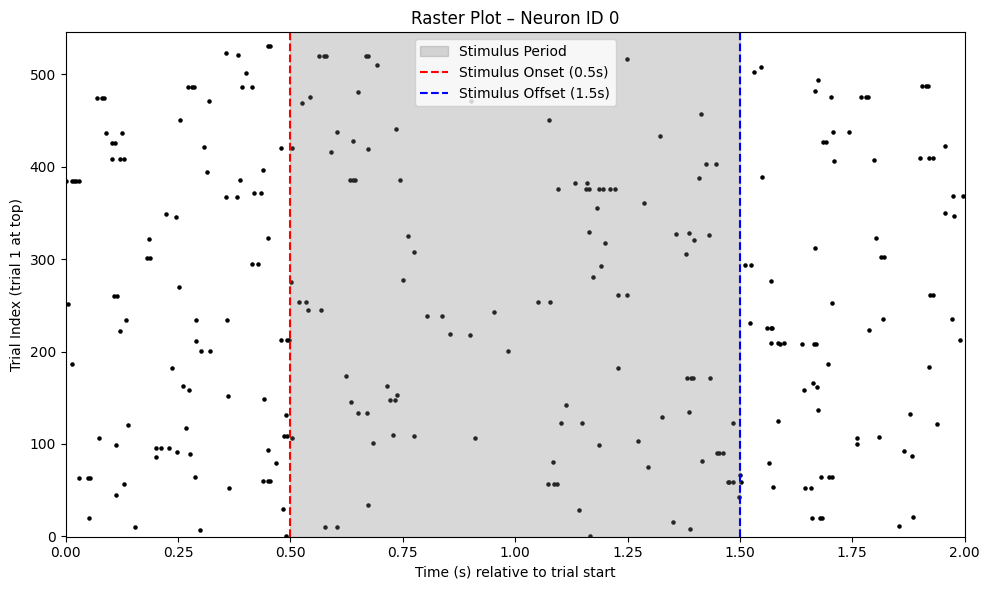

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# === STEP 1: Load Your Spike Data ===
df = pd.read_csv("spikes_full.csv")

# === STEP 2: Convert spike time strings to real lists (no lambda) ===
parsed_spikes = []
for item in df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === STEP 3: Choose ONE neuron ===
neuron_id = df["Neuron ID"].unique()[0]  # Pick first neuron
neuron_df = df[df["Neuron ID"] == neuron_id].copy()

# === STEP 4: Aggregate spike times trial-by-trial ===
raster_spike_times = []
raster_trial_indices = []

# Assign trial index with 0 = top
num_trials = len(neuron_df)

for trial_idx, spike_list in enumerate(neuron_df["Trial-Aligned Spikes (s)"]):
    trial_position = num_trials - 1 - trial_idx  # flip trial order
    for spike_time in spike_list:
        raster_spike_times.append(spike_time)
        raster_trial_indices.append(trial_position)

# === STEP 5: Plot ===
plt.figure(figsize=(10, 6))

plt.scatter(raster_spike_times, raster_trial_indices, s=5, color='black')

# Add stimulus window shading (0.5 to 1.5s)
plt.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

# Add stimulus lines
plt.axvline(0.5, color='red', linestyle='--', label="Stimulus Onset (0.5s)")
plt.axvline(1.5, color='blue', linestyle='--', label="Stimulus Offset (1.5s)")

# Labels and formatting
plt.xlabel("Time (s) relative to trial start")
plt.ylabel("Trial Index (trial 1 at top)")
plt.title(f"Raster Plot – Neuron ID {neuron_id}")
plt.xlim([0, 2.0])  # full trial duration
plt.ylim([-0.5, num_trials - 0.5])
plt.legend()
plt.tight_layout()
plt.show()

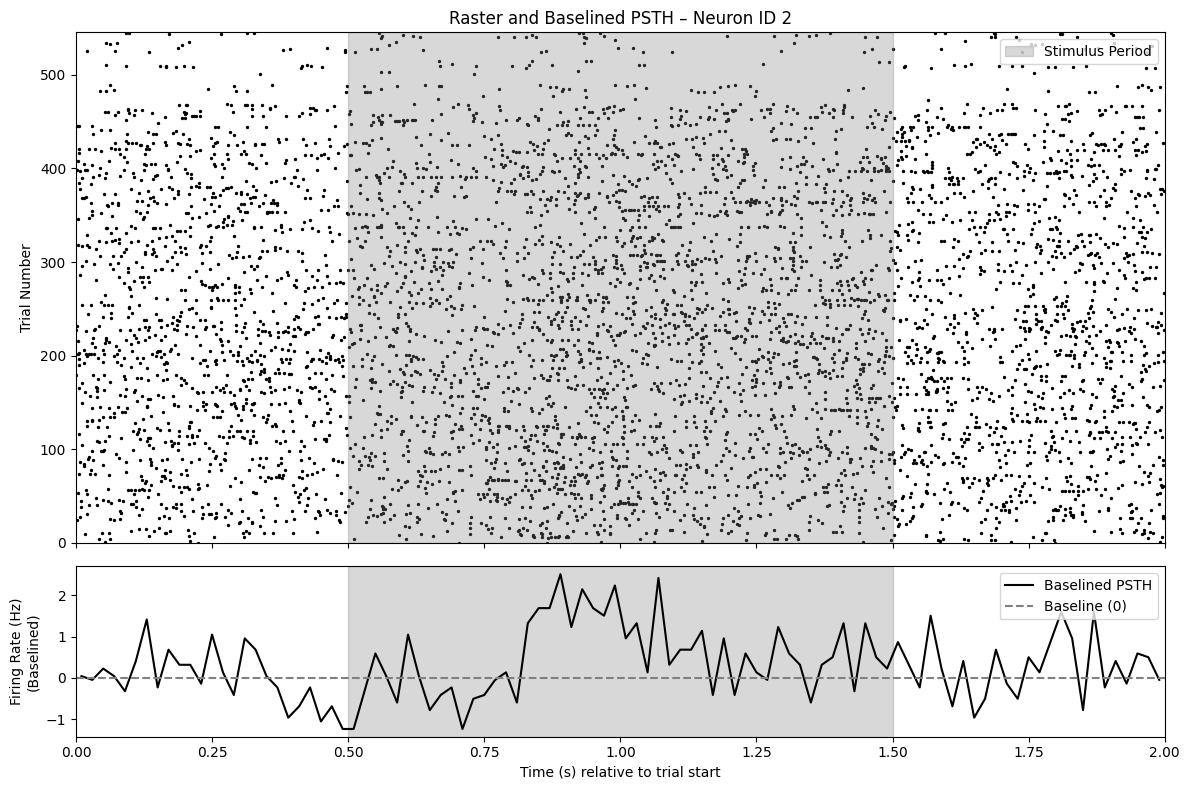

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# === Load and preprocess data ===
df = pd.read_csv("spikes_full.csv")

# Manually parse spike strings into lists 
parsed_spikes = []
for item in df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === Choose one neuron ===
neuron_id = df["Neuron ID"].unique()[2]  # choose third neuron (index 2)
neuron_df = df[df["Neuron ID"] == neuron_id].copy()

# === Raster data ===
raster_spike_times = []
raster_trial_indices = []

for trial_idx, spike_list in enumerate(neuron_df["Trial-Aligned Spikes (s)"]):
    trial_position = trial_idx  # Trial 0 at bottom, increasing upward
    for spike_time in spike_list:
        raster_spike_times.append(spike_time)
        raster_trial_indices.append(trial_position)

# === PSTH data ===
bin_size = 0.02  # 20 ms bins
edges = np.arange(0, 2.0 + bin_size, bin_size)
bin_centers = (edges[:-1] + edges[1:]) / 2

binned_counts = []
for spike_list in neuron_df["Trial-Aligned Spikes (s)"]:
    counts, _ = np.histogram(spike_list, bins=edges)
    binned_counts.append(counts)

binned_counts = np.array(binned_counts)
psth = binned_counts.mean(axis=0) / bin_size  # spikes/sec

# === Baselining (0–0.5s window) ===
baseline_bins = (bin_centers >= 0.0) & (bin_centers < 0.5)
baseline_mean = psth[baseline_bins].mean()
psth_baselined = psth - baseline_mean

# === Plot Raster + PSTH ===
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]}
)

# --- Raster plot ---
ax_raster.scatter(raster_spike_times, raster_trial_indices, s=2, color='black')

# Shaded stimulus period: 0.5 to 1.5 s
ax_raster.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

ax_raster.set_ylabel("Trial Number")
ax_raster.set_title(f"Raster and Baselined PSTH – Neuron ID {neuron_id}")
ax_raster.set_ylim([-0.5, len(neuron_df) - 0.5])
ax_raster.legend(loc='upper right')

# --- PSTH plot ---
ax_psth.plot(bin_centers, psth_baselined, color='black', label="Baselined PSTH")

# Same shading on PSTH
ax_psth.axvspan(0.5, 1.5, color='gray', alpha=0.3)

ax_psth.axhline(0, color='gray', linestyle='--', label="Baseline (0)")
ax_psth.set_xlabel("Time (s) relative to trial start")
ax_psth.set_ylabel("Firing Rate (Hz)\n(Baselined)")
ax_psth.legend(loc='upper right')

# --- Final adjustments ---
ax_raster.set_xlim([0, 2.0])
ax_psth.set_xlim([0, 2.0])

plt.tight_layout()
plt.show()

In [9]:
# === Total spike count per neuron ===
spike_counts_per_neuron = {}

for neuron_id in df["Neuron ID"].unique():
    neuron_spikes = df[df["Neuron ID"] == neuron_id]["Trial-Aligned Spikes (s)"]
    total_spikes = sum(len(spikes) for spikes in neuron_spikes)
    spike_counts_per_neuron[neuron_id] = total_spikes

# Print results
for neuron_id, count in spike_counts_per_neuron.items():
    print(f"Neuron ID {neuron_id}: {count} spikes")

Neuron ID 0: 284 spikes
Neuron ID 1: 41 spikes
Neuron ID 2: 5607 spikes
Neuron ID 3: 72 spikes
Neuron ID 4: 2038 spikes
Neuron ID 5: 2966 spikes
Neuron ID 6: 786 spikes
Neuron ID 7: 2700 spikes
Neuron ID 8: 807 spikes
Neuron ID 9: 4552 spikes
Neuron ID 10: 1403 spikes
Neuron ID 11: 36 spikes
Neuron ID 12: 608 spikes
Neuron ID 13: 809 spikes
Neuron ID 14: 90 spikes
Neuron ID 15: 145 spikes
Neuron ID 16: 1179 spikes
Neuron ID 17: 436 spikes
Neuron ID 18: 146 spikes
Neuron ID 19: 1106 spikes
Neuron ID 20: 1037 spikes
Neuron ID 21: 2974 spikes
Neuron ID 22: 4575 spikes
Neuron ID 23: 113 spikes
Neuron ID 24: 2918 spikes
Neuron ID 25: 168 spikes
Neuron ID 26: 716 spikes
Neuron ID 27: 8208 spikes
Neuron ID 28: 1626 spikes
Neuron ID 29: 39 spikes
Neuron ID 30: 83 spikes
Neuron ID 31: 33 spikes
Neuron ID 32: 13518 spikes
Neuron ID 33: 223 spikes
Neuron ID 34: 457 spikes
Neuron ID 35: 75 spikes
Neuron ID 36: 359 spikes
Neuron ID 37: 483 spikes
Neuron ID 38: 4097 spikes
Neuron ID 39: 1992 spikes


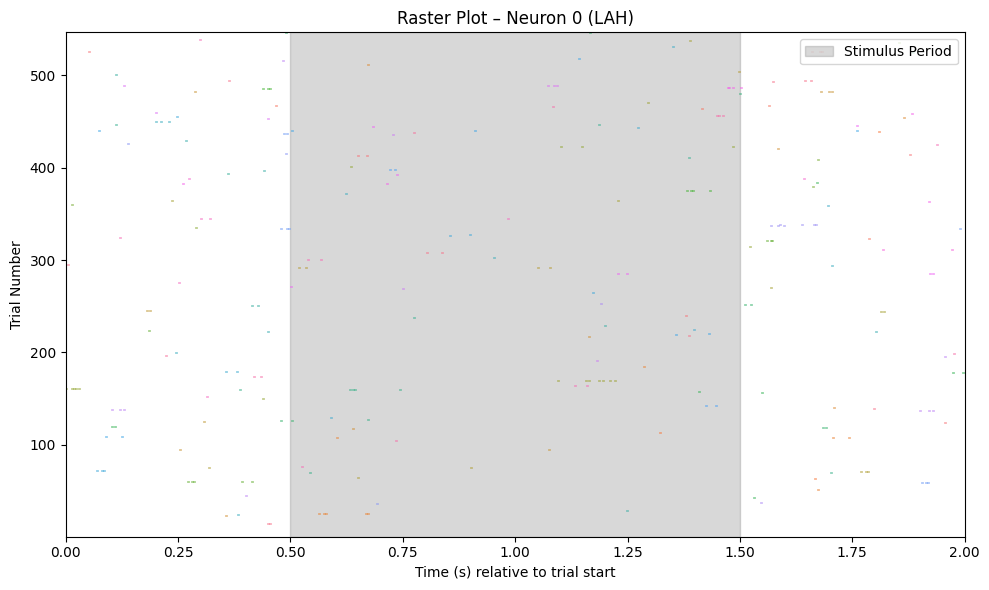

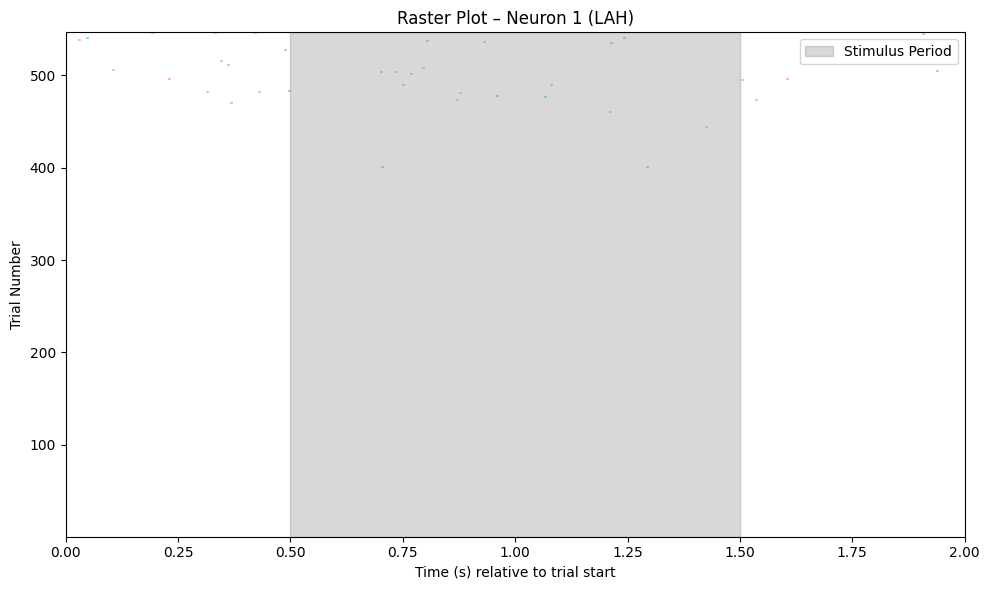

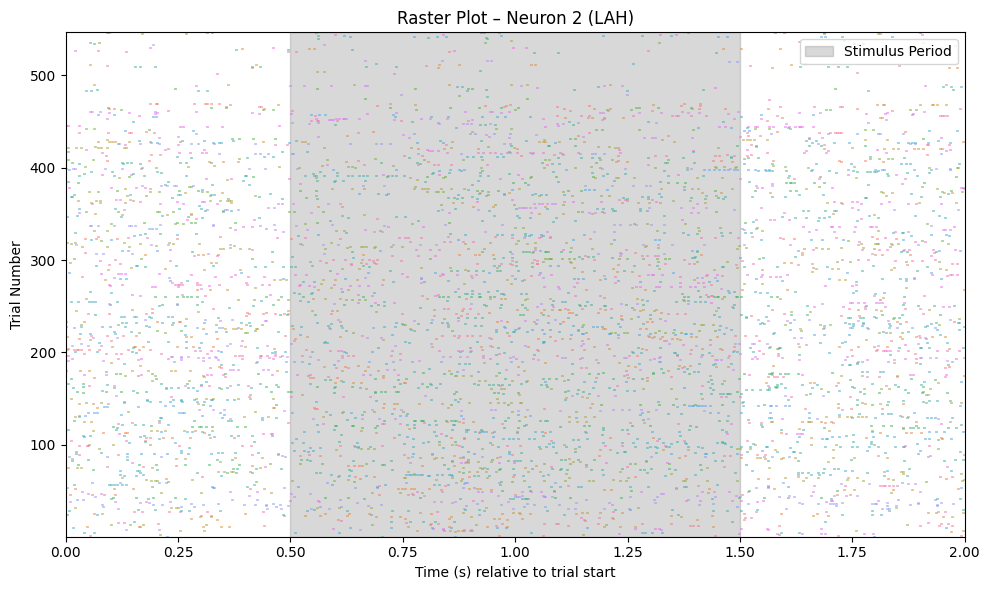

In [10]:
# ===============================
# Raster Plot Colored by Identity (Fixed X-Axis and Stimulus Shading)
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# === Step 1: Load Full Spike Data ===
df = pd.read_csv("spikes_full.csv")

# Parse spike times from strings into lists
parsed_spikes = []
for item in df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === Step 2: Select Neurons You Want to Plot ===
selected_neurons = [0, 1, 2]  # You can change this list

# === Step 3: Helper Function – Extract Spikes and Identity Labels ===
def extract_spikes_and_labels(neuron_df):
    spike_times = []
    trial_identities = []
    
    for trial_id, trial_data in neuron_df.groupby("Trial ID"):
        combined_spikes = []
        for spike_list in trial_data["Trial-Aligned Spikes (s)"]:
            combined_spikes.extend(spike_list)
        combined_spikes = sorted(combined_spikes)
        spike_times.append(combined_spikes)

        if "Identity" in trial_data.columns:
            identity = trial_data["Identity"].iloc[0] if not pd.isna(trial_data["Identity"].iloc[0]) else "Unknown"
        else:
            identity = "Unknown"
        trial_identities.append(identity)
    
    return spike_times, trial_identities

# === Step 4: Helper Function – Plot Raster ===
def plot_raster(spikes, identities, neuron_id, brain_region):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Color mapping per identity
    identities = np.array(identities).astype(str)
    unique_identities = np.unique(identities)
    colors = sns.color_palette("husl", len(unique_identities))
    color_map = {identity: colors[i] for i, identity in enumerate(unique_identities)}
    
    # Plot each trial
    for trial_idx, (trial_spikes, identity) in enumerate(zip(spikes, identities)):
        color = color_map.get(identity, "gray")
        ax.vlines(trial_spikes, trial_idx + 0.5, trial_idx + 1.5, color=color, linewidth=2)

    # === Stimulus Period Shading ===
    ax.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

    # Labels and formatting
    ax.set_xlim([0, 2.0])  # Full trial: 0 to 2 seconds
    ax.set_ylim([0.5, len(spikes) + 0.5])
    ax.set_xlabel("Time (s) relative to trial start")
    ax.set_ylabel("Trial Number")
    ax.set_title(f"Raster Plot – Neuron {neuron_id} ({brain_region})")
    ax.legend()
    plt.tight_layout()
    plt.show()

# === Step 5: Loop Through Neurons and Plot ===
for neuron_id in selected_neurons:
    neuron_df = df[df["Neuron ID"] == neuron_id]

    if neuron_df.empty:
        print(f"No data for Neuron {neuron_id}. Skipping...")
        continue

    spikes, identities = extract_spikes_and_labels(neuron_df)

    if "Neuron Area" in neuron_df.columns:
        brain_region = neuron_df["Neuron Area"].dropna().iloc[0] if not neuron_df["Neuron Area"].isna().all() else "Unknown"
    else:
        brain_region = "Unknown"

    plot_raster(spikes, identities, neuron_id, brain_region)

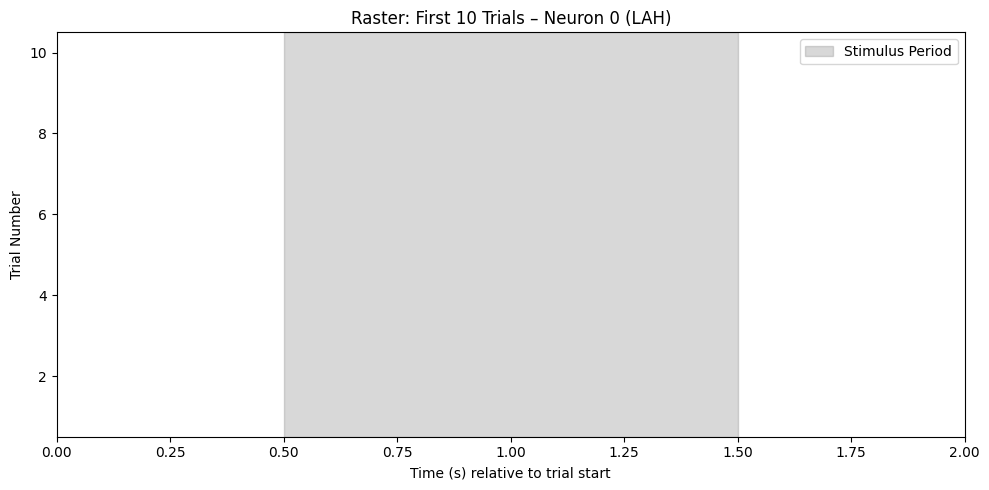

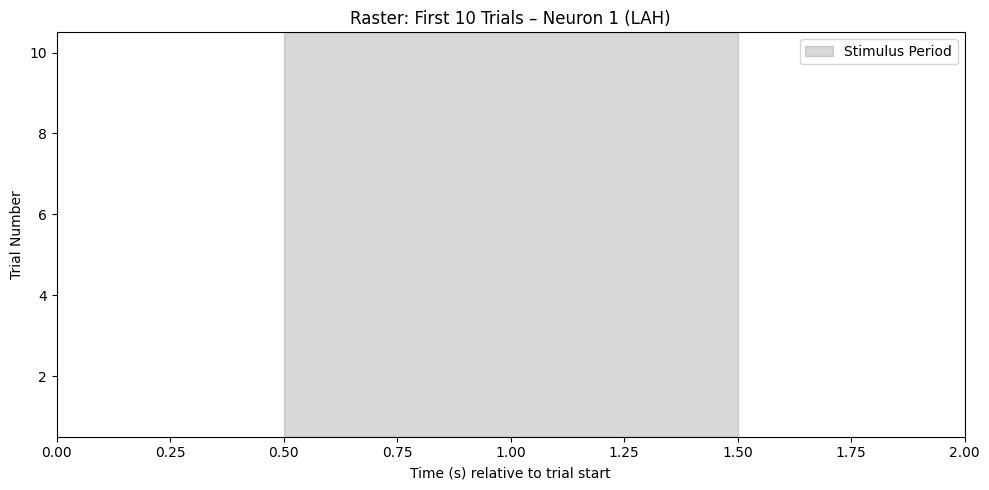

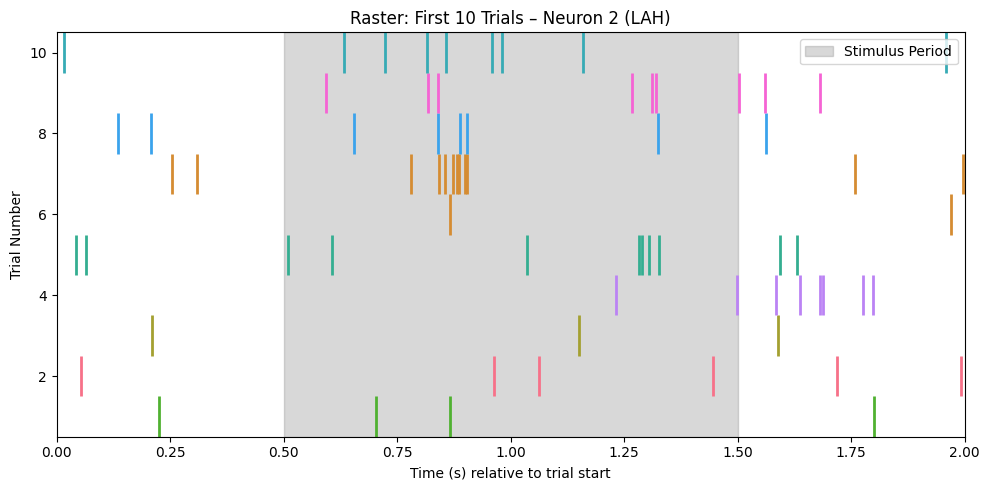

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# === STEP 1: Load spike data ===
df = pd.read_csv("spikes_full.csv")

# === STEP 2: Parse spike strings into real lists (no lambda) ===
parsed_spikes = []
for item in df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === STEP 3: Choose neurons ===
selected_neurons = [0, 1, 2]  # You can change these
n_trials_to_plot = 10         # <-- Change this easily

# === STEP 4: Loop through neurons ===
for neuron_id in selected_neurons:
    neuron_data = df[df["Neuron ID"] == neuron_id]
    
    if neuron_data.empty:
        print(f"⚠️ Neuron {neuron_id} not found. Skipping...")
        continue

    # Sort trials and keep only first N
    neuron_data_sorted = neuron_data.sort_values("Trial ID").drop_duplicates("Trial ID")
    neuron_data_first_trials = neuron_data_sorted.head(n_trials_to_plot)

    # Extract spikes and identities
    spikes_per_trial = []
    identity_labels = []

    for trial_id in neuron_data_first_trials["Trial ID"]:
        trial_rows = neuron_data[neuron_data["Trial ID"] == trial_id]
        combined_spikes = []

        for spike_list in trial_rows["Trial-Aligned Spikes (s)"]:
            if not spike_list:
                continue
            combined_spikes.extend(spike_list)

        spikes_per_trial.append(sorted(combined_spikes))

        if not trial_rows["Identity"].isna().all():
            identity = trial_rows["Identity"].values[0]
        else:
            identity = "Unknown"
        identity_labels.append(identity)

    # Get brain area
    brain_region = neuron_data["Neuron Area"].dropna().values[0] if not neuron_data["Neuron Area"].isna().all() else "Unknown"

    # === STEP 5: Plot ===
    fig, ax = plt.subplots(figsize=(10, 5))

    identities = np.array(identity_labels, dtype=str)
    unique_ids = np.unique(identities)
    colors = sns.color_palette("husl", len(unique_ids))
    color_map = {uid: colors[i] for i, uid in enumerate(unique_ids)}

    for i, (trial_spikes, identity) in enumerate(zip(spikes_per_trial, identities)):
        color = color_map.get(identity, "gray")
        ax.vlines(trial_spikes, i + 0.5, i + 1.5, color=color, linewidth=2.0)

    # Shade stimulus window (0.5 to 1.5 s)
    ax.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

    ax.set_title(f"Raster: First {n_trials_to_plot} Trials – Neuron {neuron_id} ({brain_region})")
    ax.set_xlabel("Time (s) relative to trial start")
    ax.set_ylabel("Trial Number")
    ax.set_xlim([0, 2.0])
    ax.set_ylim([0.5, n_trials_to_plot + 0.5])
    ax.legend()
    plt.tight_layout()
    plt.show()

Plotting Neuron 32...


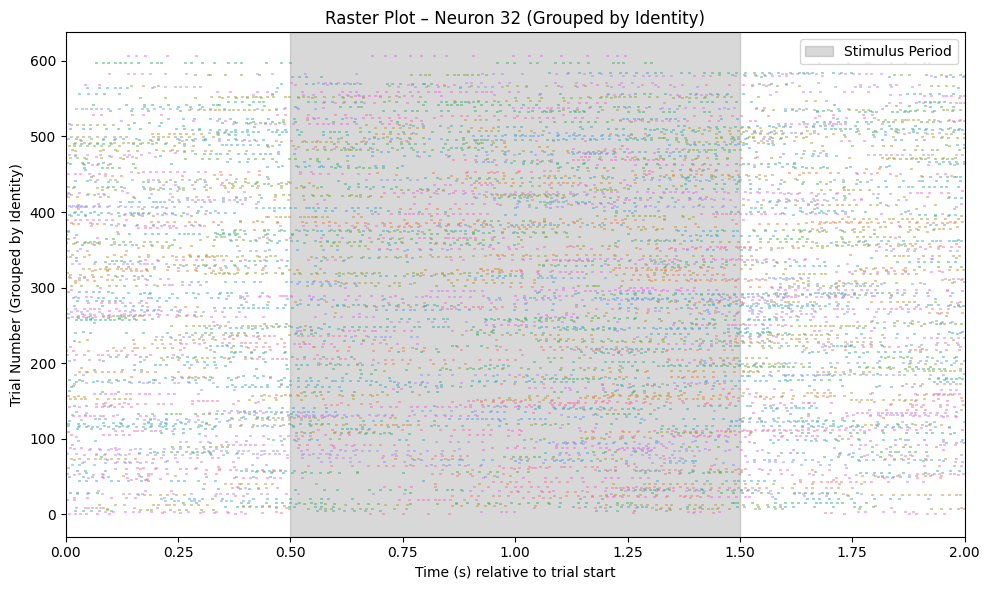

Plotting Neuron 27...


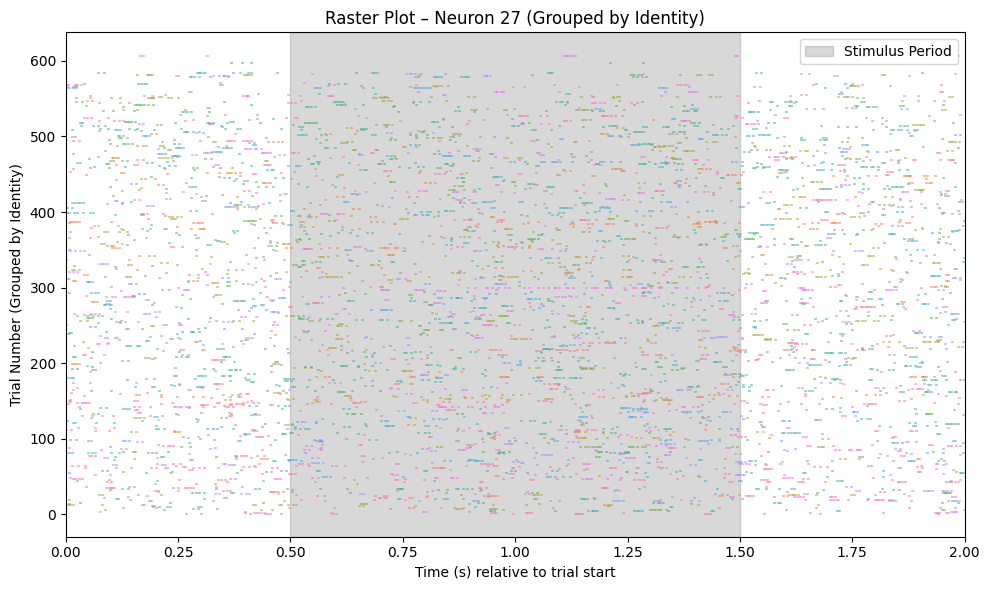

Plotting Neuron 2...


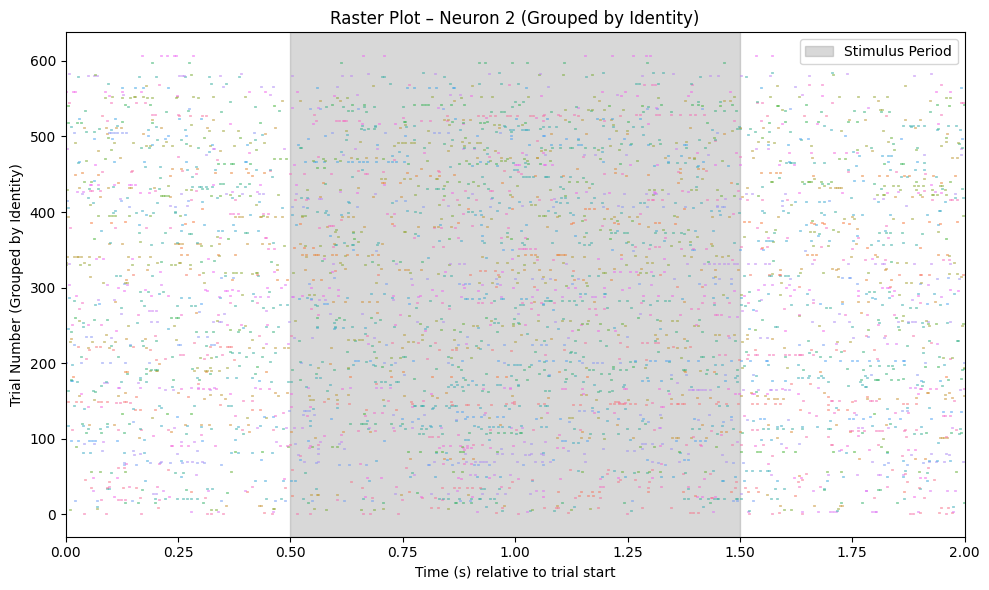

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# === STEP 1: Load the full spike data ===
spike_df = pd.read_csv("spikes_full.csv")

# === STEP 2: Parse spike times (no lambda, manual parsing) ===
parsed_spikes = []
for item in spike_df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
spike_df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === STEP 3: Select neurons you want to visualize ===
selected_neurons = [32, 27, 2]  # <-- Replace with your neuron IDs

# === STEP 4: Sort trials by identity for grouping ===
sorted_trials = spike_df.sort_values(by="Identity")

# === STEP 5: Assign colors to each unique identity ===
unique_identities = sorted_trials["Identity"].dropna().unique()
color_palette = sns.color_palette("husl", len(unique_identities))
identity_color_map = dict(zip(unique_identities, color_palette))

# === STEP 6: Loop through each neuron and plot ===
for neuron_id in selected_neurons:
    print(f"Plotting Neuron {neuron_id}...")

    spike_times_all = []
    trial_indices = []
    line_colors = []

    # Get this neuron's data
    neuron_data = spike_df[spike_df["Neuron ID"] == neuron_id]

    # Go through trials in sorted identity order
    for trial_index, trial_id in enumerate(sorted_trials["Trial ID"].unique()):
        trial_data = neuron_data[neuron_data["Trial ID"] == trial_id]

        if trial_data.empty:
            continue

        # Get the identity label
        identity = trial_data["Identity"].values[0]
        color = identity_color_map.get(identity, "gray")

        # Get all spikes for this trial
        trial_spikes = []
        for spikes in trial_data["Trial-Aligned Spikes (s)"]:
            if isinstance(spikes, list):
                trial_spikes.extend(spikes)

        if not trial_spikes:
            continue

        spike_times_all.append(trial_spikes)
        trial_indices.append(trial_index)
        line_colors.append(color)

    # === STEP 7: Plot ===
    plt.figure(figsize=(10, 6))

    for i, spikes in enumerate(spike_times_all):
        trial_y = trial_indices[i]
        color = line_colors[i]
        plt.vlines(spikes, trial_y + 0.5, trial_y + 1.5, color=color, linewidth=2.0)

    # Shade stimulus window (0.5s to 1.5s)
    plt.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

    plt.title(f"Raster Plot – Neuron {neuron_id} (Grouped by Identity)")
    plt.xlabel("Time (s) relative to trial start")
    plt.ylabel("Trial Number (Grouped by Identity)")
    plt.xlim([0, 2.0])
    plt.legend()
    plt.tight_layout()
    plt.show()

Plotting Neuron 0...


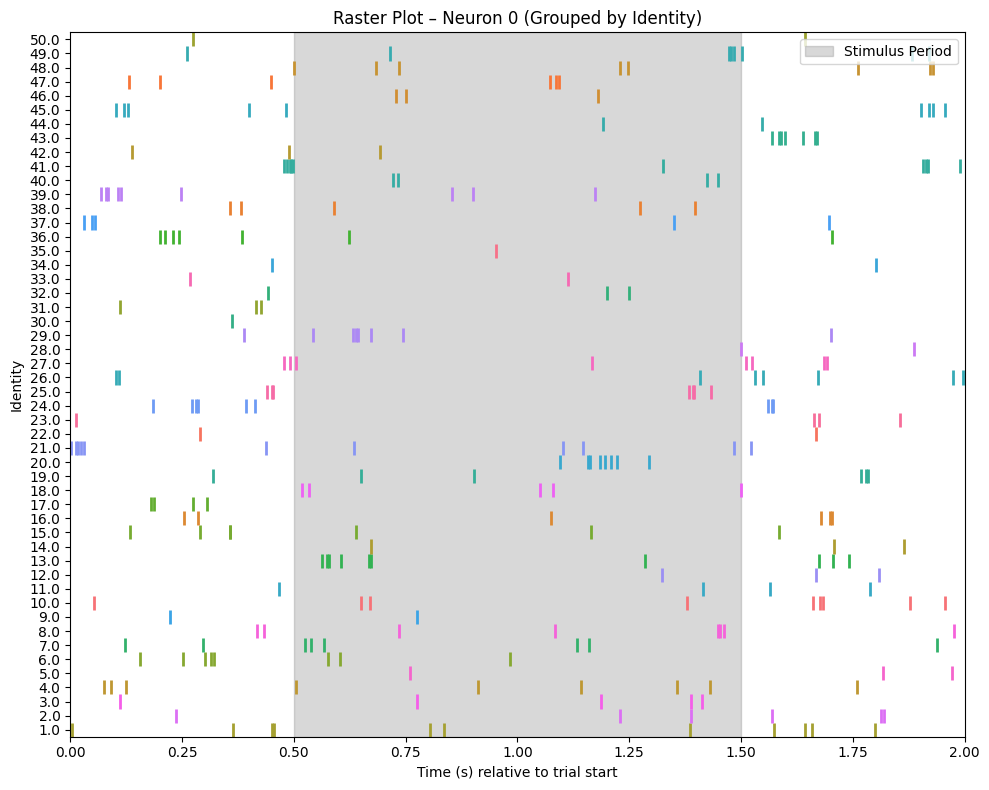

Plotting Neuron 1...


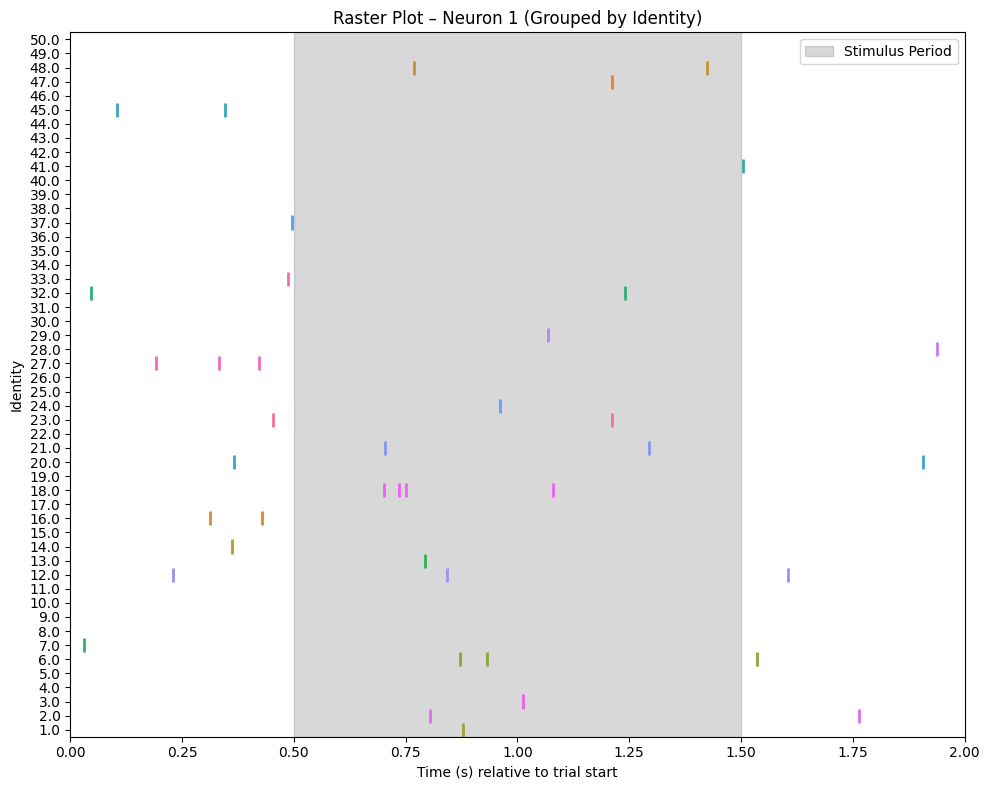

Plotting Neuron 2...


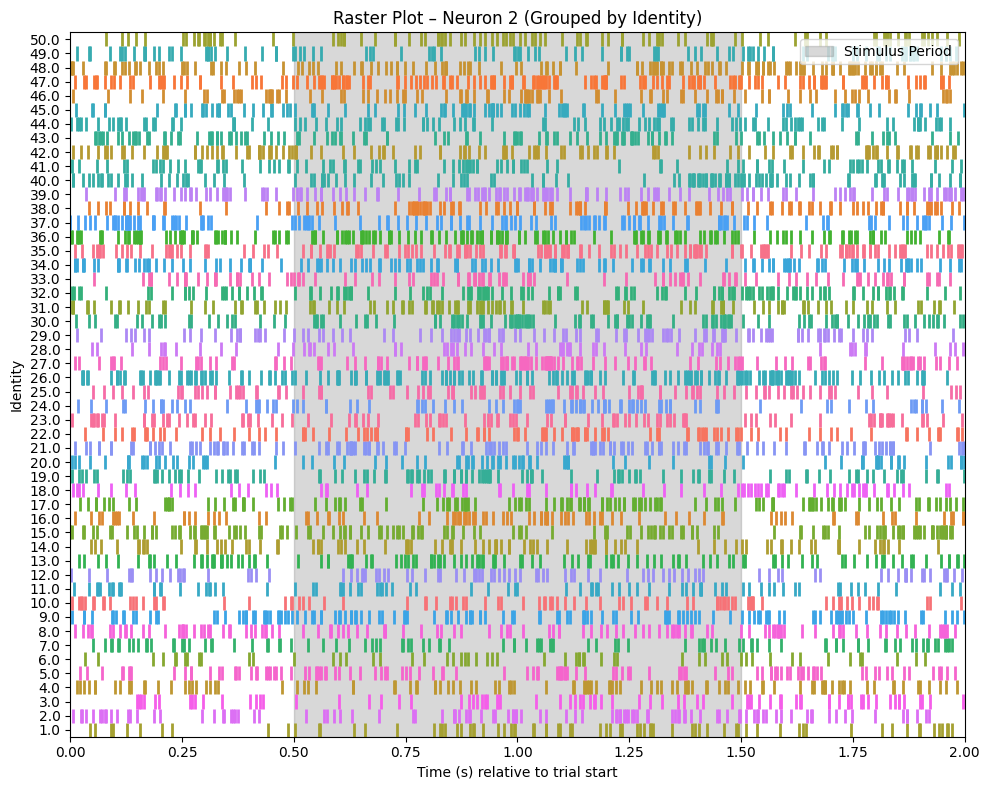

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import numpy as np

# === STEP 1: Load the spike data ===
spike_df = pd.read_csv("spikes_full.csv")

# === STEP 2: Parse spike times manually (no lambda) ===
parsed_spikes = []
for item in spike_df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
spike_df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === STEP 3: Select neurons to plot ===
selected_neurons = [0, 1, 2]  # <-- Change these as you wish

# === STEP 4: Get all unique identities and assign colors ===
unique_identities = spike_df["Identity"].dropna().unique()
color_palette = sns.color_palette("husl", len(unique_identities))
identity_to_color = dict(zip(unique_identities, color_palette))

# === STEP 5: Loop through selected neurons and create plot ===
for neuron_id in selected_neurons:
    print(f"Plotting Neuron {neuron_id}...")

    neuron_data = spike_df[spike_df["Neuron ID"] == neuron_id]

    if neuron_data.empty:
        print(f"No data found for Neuron {neuron_id}. Skipping...")
        continue

    plt.figure(figsize=(10, 8))

    # Loop through each identity (this will be the y-axis)
    for identity_idx, identity in enumerate(sorted(unique_identities)):
        trials = neuron_data[neuron_data["Identity"] == identity]

        for _, row in trials.iterrows():
            spikes = row["Trial-Aligned Spikes (s)"]
            if not isinstance(spikes, list) or not spikes:
                continue

            # Plot each spike as vertical lines
            plt.vlines(spikes, identity_idx + 0.5, identity_idx + 1.5,
                       color=identity_to_color.get(identity, "gray"), linewidth=2.0)

    # === STEP 6: Add stimulus period and labels ===
    plt.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

    plt.xlabel("Time (s) relative to trial start")
    plt.ylabel("Identity")
    plt.title(f"Raster Plot – Neuron {neuron_id} (Grouped by Identity)")

    plt.yticks(
        ticks=np.arange(1, len(unique_identities) + 1),
        labels=[str(i) for i in sorted(unique_identities)]
    )

    plt.xlim([0, 2.0])
    plt.ylim([0.5, len(unique_identities) + 0.5])
    plt.legend()
    plt.tight_layout()
    plt.show()

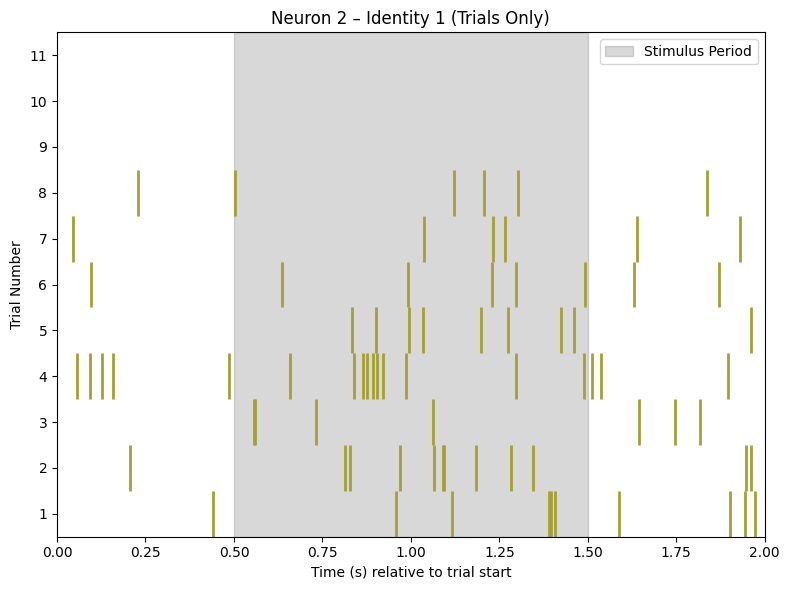

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# === STEP 1: Load your spike file ===
df = pd.read_csv("spikes_full.csv")

# === STEP 2: Parse spike times manually (no lambda) ===
parsed_spikes = []
for item in df["Trial-Aligned Spikes (s)"]:
    if pd.isna(item) or item == "[]":
        parsed_spikes.append([])
    else:
        parsed_spikes.append(ast.literal_eval(item))
df["Trial-Aligned Spikes (s)"] = parsed_spikes

# === STEP 3: Choose neuron and identity ===
neuron_id = 2
identity_value = 1  # or "cat" if your identities are strings

# === STEP 4: Assign consistent color to each identity ===
unique_identities = df["Identity"].dropna().unique()
color_palette = sns.color_palette("husl", len(unique_identities))
identity_to_color = dict(zip(unique_identities, color_palette))

# Get the color for the identity you're plotting
identity_color = identity_to_color.get(identity_value, "black")

# === STEP 5: Filter the data ===
filtered_df = df[(df["Neuron ID"] == neuron_id) & (df["Identity"] == identity_value)]

# === STEP 6: Collect spikes trial by trial ===
spikes_per_trial = []

for trial_id in filtered_df["Trial ID"].unique():
    trial_data = filtered_df[filtered_df["Trial ID"] == trial_id]
    combined_spikes = []

    for spike_list in trial_data["Trial-Aligned Spikes (s)"]:
        if not isinstance(spike_list, list) or len(spike_list) == 0:
            continue
        combined_spikes.extend(spike_list)

    spikes_per_trial.append(sorted(combined_spikes))

# === STEP 7: Plot the raster ===
plt.figure(figsize=(8, 6))

for i, trial_spikes in enumerate(spikes_per_trial):
    plt.vlines(trial_spikes, i + 0.5, i + 1.5, color=identity_color, linewidth=2.0)

# Add stimulus period (gray shaded area)
plt.axvspan(0.5, 1.5, color='gray', alpha=0.3, label="Stimulus Period")

# Formatting
plt.title(f"Neuron {neuron_id} – Identity {identity_value} (Trials Only)")
plt.xlabel("Time (s) relative to trial start")
plt.ylabel("Trial Number")
plt.xlim([0, 2.0])
plt.ylim([0.5, len(spikes_per_trial) + 0.5])
plt.yticks(range(1, len(spikes_per_trial) + 1))
plt.legend()
plt.tight_layout()
plt.show()